<a href="https://colab.research.google.com/github/lumi62/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pyspark

In [8]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [9]:
spark = SparkSession.builder.appName("Customer_Churn_prediction").getOrCreate()
spark

In [10]:
data = spark.read.format('csv').option("inferSchema", True).option("header", True).load("dataset.csv")
data.show(4)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [11]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
data.count()

7043

In [13]:
len(data.columns)

21

In [14]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [15]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [16]:
numerical_columns = [name for name,typ in data.dtypes if typ == "double" or typ=="int"]
numerical_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

In [17]:
categorical_columns = [name for name,typ in data.dtypes if typ == "string"]
categorical_columns


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [18]:
data.select(numerical_columns).show()

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
|     8|         99.65|       820.5|
|    22|          89.1|      1949.4|
|    10|         29.75|       301.9|
|    28|         104.8|     3046.05|
|    62|         56.15|     3487.95|
|    13|         49.95|      587.45|
|    16|         18.95|       326.8|
|    58|        100.35|      5681.1|
|    49|         103.7|      5036.3|
|    25|         105.5|     2686.05|
|    69|        113.25|     7895.15|
|    52|         20.65|     1022.95|
|    71|         106.7|     7382.25|
|    10|          55.2|      528.35|
|    21|         90.05|      1862.9|
+------+--------------+------------+
only showing top 20 rows



In [19]:
df = data.select(numerical_columns).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


/tmp/ipython-input-20-1957288238.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins = 20)


,tenure
count,7043.000000
mean,32.435752
std,25.075228
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,458.000000


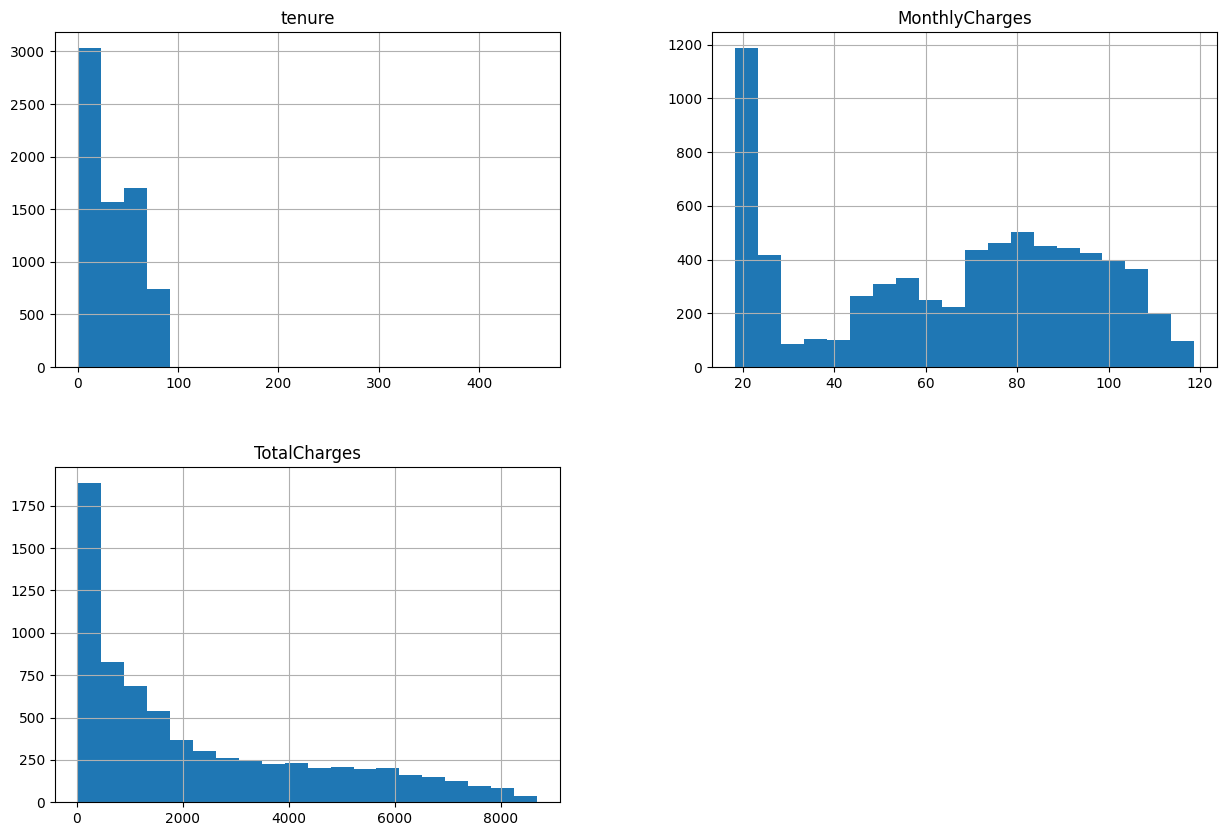

In [20]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df.hist(ax=ax, bins = 20)
df.tenure.describe()

In [21]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


In [22]:
for column in categorical_columns:
  data.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

In [23]:
columns_with_missing_values =["TotalCharges"]

In [24]:
imputer = Imputer(inputCols = columns_with_missing_values, outputCols=columns_with_missing_values).setStrategy("mean")

In [25]:
imputer = imputer.fit(data)
data_imputed = imputer.transform(data)

In [26]:
data.printSchema()


root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [27]:
data_imputed.select("TotalCharges").where(col("TotalCharges").isNull()).count()


0

In [28]:
data.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in data.columns
]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [29]:
from pyspark.sql.functions import when, trim, col

# Replace blank strings with nulls
data = data.withColumn(
    "TotalCharges",
    when(trim(col("TotalCharges")) == "", None).otherwise(col("TotalCharges"))
)


In [30]:
data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))


In [31]:
data.select(count(when(col("TotalCharges").isNull(), "TotalCharges"))).show()


+-------------------------------------------------------------+
|count(CASE WHEN (TotalCharges IS NULL) THEN TotalCharges END)|
+-------------------------------------------------------------+
|                                                           11|
+-------------------------------------------------------------+



In [32]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=["TotalCharges"],
    outputCols=["TotalCharges"],
    strategy="mean"
)

data = imputer.fit(data).transform(data)


In [33]:
data.select(count(when(col("TotalCharges").isNull(), "TotalCharges")).alias("TotalCharges_Nulls")).show()


+------------------+
|TotalCharges_Nulls|
+------------------+
|                 0|
+------------------+



In [34]:
data.select("*").where(data.tenure>100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [35]:
print("before Removing the outlier", data.count())
data= data.filter(data.tenure<100)
print("After Removing the outlier", data.count())

before Removing the outlier 7043
After Removing the outlier 7042


In [36]:
numerical_vector_assemmbler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features_vector")
data = numerical_vector_assemmbler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------

In [37]:
scaler = StandardScaler(inputCol="numerical_features_vector", outputCol="numerical_features_scaled", withStd=True, withMean =True)
data = scaler.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------

In [38]:
categorical_columns_indexed =[name + "_indexed" for name in categorical_columns]
Indexer = StringIndexer(inputCols=categorical_columns, outputCols=categorical_columns_indexed)
data = Indexer.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       Pa

In [39]:
categorical_columns_indexed.remove("customerID_indexed")
categorical_columns_indexed.remove("Churn_indexed")
caterogical_vector_assembler = VectorAssembler(inputCols=categorical_columns_indexed, outputCol="categorical_features_vector")
data = caterogical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contrac

In [40]:
data = data.drop("final_feature_vector")

final_vector_assembler = VectorAssembler(inputCols=["numerical_features_scaled", "categorical_features_vector"], outputCol="final_feature_vector")
data = final_vector_assembler.transform(data)
data.select(["final_feature_vector", "Churn_indexed"]).show()

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,1,2,3,5,7,...|          0.0|
|(19,[0,1,2,9,10,1...|          0.0|
|(19,[0,1,2,9,10,1...|          1.0|
|[0.51406079695460...|          0.0|
|(19,[0,1,2,3],[-1...|          1.0|
|(19,[0,1,2,3,8,12...|          1.0|
|(19,[0,1,2,6,8,11...|          0.0|
|(19,[0,1,2,3,7,8,...|          0.0|
|(19,[0,1,2,3,5,8,...|          1.0|
|(19,[0,1,2,6,9,10...|          0.0|
|(19,[0,1,2,5,6,9,...|          0.0|
|[-0.6667820073655...|          0.0|
|(19,[0,1,2,5,8,12...|          0.0|
|(19,[0,1,2,8,11,1...|          1.0|
|(19,[0,1,2,10,12,...|          0.0|
|[1.49131001432301...|          0.0|
|[0.79909181868705...|          0.0|
|[1.57274744910371...|          0.0|
|(19,[0,1,2,3,5,6,...|          1.0|
|(19,[0,1,2,3,11,1...|          0.0|
+--------------------+-------------+
only showing top 20 rows



In [41]:
train,test = data.randomSplit([0.7, 0.3], seed=100)
test.count()

2112

In [42]:
train.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    Streamin

In [58]:
dt = DecisionTreeClassifier(featuresCol="final_feature_vector", labelCol="Churn_indexed", maxDepth = 6)
model = dt.fit(train)

In [59]:
predictions_test =model.transform(test)
predictions_test.select(["Churn", "prediction"]).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



In [60]:
evaluator =BinaryClassificationEvaluator(labelCol="Churn_indexed")
auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName : "areaUnderROC"})
auc_test

0.7968193482241807

In [61]:
predictions_train=model.transform(train)
auc_train = evaluator.evaluate(predictions_train, {evaluator.metricName : "areaUnderROC"})
auc_train

0.7976224624061719

In [47]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

In [48]:
maxDepths= [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_accs, train_accs = evaluate_dt(maxDepths)
print(test_accs)
print(train_accs)

[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968193482241807, 0.7459929239831928, 0.7488440727988194, 0.7386656315374632, 0.7576090885924416, 0.7710641878878031, 0.7682248916966439, 0.7483486330960832, 0.7342303794617724, 0.718568321490586, 0.7088379094340964, 0.7003988408133272, 0.7003609124150315, 0.6919692542921316, 0.6880632218989089]
[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.7976224624061719, 0.7600923189684357, 0.7612806499975817, 0.785827435281247, 0.8263588936899737, 0.8631097062703353, 0.8896763728814125, 0.9232336695945687, 0.9403882249642699, 0.9524972983474892, 0.9669533281190329, 0.9768541758042003, 0.9815983276437421, 0.9863893831727073, 0.9887012139091744]


In [50]:
df = pd.DataFrame()
df["maxDepth"] = maxDepths
df["testAcc"] = test_accs
df["trainAcc"] = train_accs
px.line(df, x ="maxDepth", y =["testAcc", "trainAcc"])

In [64]:
feature_importance = model.featureImportances
scores = [ score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns = ["score"],index = categorical_columns_indexed+numerical_columns)
px.bar(df, y="score")

In [65]:
df = data. groupby(["tenure","Churn"]).count().toPandas()
px.bar(df, x="tenure", y="count", color="Churn")